In [1]:
import cv2
import numpy as np
import rawpy
import shutil
from data import common
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from data import common
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
def imshows(ims, figsize=None, titles=[]):
    figsize = figsize or (len(ims) * 6, 4)
    plt.figure(figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(1, len(ims), i + 1)
        plt.imshow(im)
        if len(titles) > i:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

Let's prepare rgb files

In [3]:
base = Path('dataset/SRRAW/test')

In [4]:
save_path = base / "rgb_HR"
save_path.mkdir(exist_ok=True)


for p in base.glob("*[0-9]"):
    try:
        img = cv2.imread(str(p / '00001.jpg'))
        h, w, c = img.shape
        ix, iy = int(h/12) * 6, int(w/12) * 6
        cx, cy = int(h/2), int(w/2)
        img = img[cx - ix:cx + ix, cy - iy:cy + iy, :]
        cv2.imwrite(str(save_path / "{}.JPG".format(p.name)), img)
        
    except Exception as e:
        print(base.name, p.name, e)
    finally:
        pass

In [5]:
source_path = base / "rgb_HR"
save_path = base / "rgb_LR_bicubic"
save_path.mkdir(exist_ok=True)

for p in source_path.glob("*.JPG"):
    try:
        img = cv2.imread(str(p))
        h, w, c = img.shape
        for scale in [2, 3, 4]:
            ch, cw = int(h/scale), int(w/scale)
            assert ch*scale == h and ch*scale == h, "Scale error!"
            img = cv2.resize(img, dsize=(cw, ch), interpolation=cv2.INTER_CUBIC)
            target_path = save_path / "X{:1d}".format(scale)
            target_path.mkdir(exist_ok=True)
            name = target_path / "{}X{:1d}{}".format(p.stem, scale, p.suffix)
            cv2.imwrite(str(name), img)
    except Exception as e:
        print(p.name, e)
    finally:
        pass

From here, deal with raw image

In [4]:
save_path = base / "raw_HR"
save_path.mkdir(exist_ok=True)


for p in base.glob("*[0-9]"):
    try:
        img = str(p / '00001.ARW')
        target = str(save_path / "{}.ARW".format(p.name))
        shutil.move(img, target)
        
    except Exception as e:
        print(base.name, p.name, e)
    finally:
        pass

In [2]:
from data.common import get_4ch, get_1ch, get_bayer

TODO 요기는 pool 로 만들어도 좋을듯 ...

In [3]:
base = Path('dataset/SRRAW/train')

In [16]:
source = base / "raw_HR"
target = base / "raw_HR_binary"
lr_target = base / "raw_LR_binary"
target.mkdir(exist_ok=True)
lr_target.mkdir(exist_ok=True)

with Pool(4) as pool:
    
    for p in tqdm(list(source.glob("*.ARW")), ncols=100):
        try:
            bayer = get_bayer(str(p))
            raw = get_4ch(bayer)
            h, w, c = raw.shape
            ix, iy = int(h/12) * 6, int(w/12) * 6
            cx, cy = int(h/2), int(w/2)
            raw = raw[cx - ix:cx + ix, cy - iy:cy + iy, :]
            name = target / p.stem
            np.save(name, raw)
    
            h, w, c = raw.shape
            for scale in [2, 3, 4]:
                ch, cw = int(h/scale), int(w/scale)
                assert ch*scale == h and ch*scale == h, "Scale error!"
                lr = cv2.resize(raw, dsize=(cw, ch), interpolation=cv2.INTER_CUBIC)
                target_path = lr_target / "X{:1d}".format(scale)
                target_path.mkdir(exist_ok=True)
                name = target_path / "{}X{:1d}".format(p.stem, scale)
                np.save(name, lr)
    
        except Exception as e:
            print(p.name, e)
        finally:
            pass
            

100%|█████████████████████████████████████████████████████████████| 450/450 [05:47<00:00,  1.30it/s]


In [18]:
raw_lr = np.load(list((lr_target / "X2").glob("*"))[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


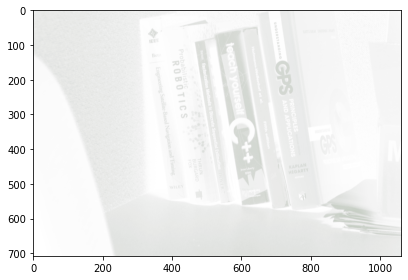

In [20]:
imshows([raw_lr])

In [20]:
source = list((base / "raw_HR").glob("*"))
target = list((base / "rgb_HR").glob("*"))

In [49]:
source_img = rawpy.imread(str(source[0]))
source_img = source_img.postprocess(no_auto_bright=False, use_camera_wb=True, output_bps=8)

In [22]:
target_img = cv2.imread(str(target[0]))
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

In [ ]:
source_img

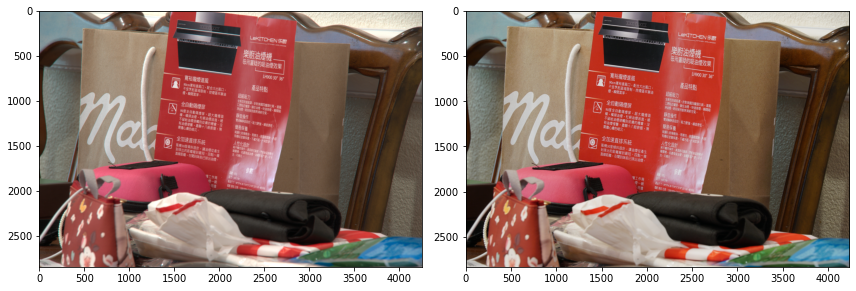

In [50]:
imshows([source_img, target_img])

In [199]:
source_gray = cv2.cvtColor(source_img, cv2.COLOR_RGB2GRAY)
target_gray = cv2.cvtColor(target_img, cv2.COLOR_RGB2GRAY)

#source_gray = cv2.resize(source_gray, dsize=(0,0), fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)
#target_gray = cv2.resize(target_gray, dsize=(0,0), fx=0.50, fy=0.50, interpolation=cv2.INTER_LINEAR)

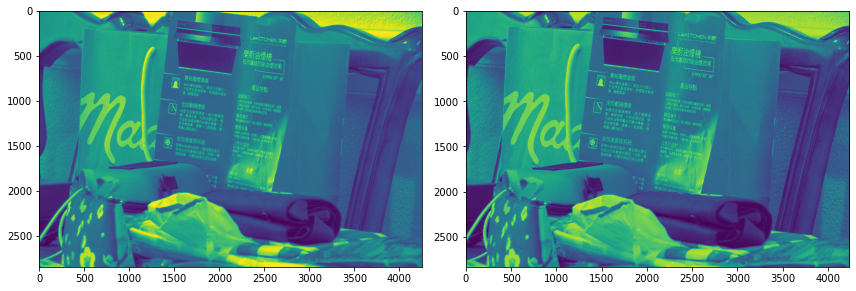

In [200]:
imshows([source_gray, target_gray])

In [138]:
warp_mode = cv2.MOTION_TRANSLATION
warp_matrix = np.eye(2, 3, dtype=np.float32)
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1500, 1e-8)

In [146]:
_, warp_matrix = cv2.findTransformECC(target_gray[300:700, 300:700], source_gray[300:700, 300:700], warp_matrix, warp_mode, criteria, None, 1)

In [159]:
import random

In [162]:
def get_patch(*args, patch_size=96, scale=1, input_large=False):
    ih, iw = args[0].shape[:2]

    if not input_large:
        p = scale
        tp = p * patch_size
        ip = tp // scale
    else:
        tp = patch_size
        ip = patch_size

    ix = random.randrange(0, iw - ip + 1)
    iy = random.randrange(0, ih - ip + 1)

    if not input_large:
        tx, ty = scale * ix, scale * iy
    else:
        tx, ty = ix, iy

    ret = [
        args[0][iy:iy + ip, ix:ix + ip],
        *[a[ty:ty + tp, tx:tx + tp] for a in args[1:]]
    ]
    return ret

In [224]:
warp_mode = cv2.MOTION_TRANSLATION
warp_matrix = np.eye(2, 3, dtype=np.float32)
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1500, 1e-3)

In [204]:
def patch_matrix_yield(target, source, patch_size, warp_mode, warp_matrix, criteria):
    while True:
        t_patch, s_patch = get_patch(target, source, patch_size=patch_size)
        _, warp_matrix = cv2.findTransformECC(t_patch, s_patch, warp_matrix, warp_mode, criteria, None, 1)
        yield warp_matrix

In [218]:
t_path, s_patch = get_patch(target_gray, source_gray, patch_size=300)

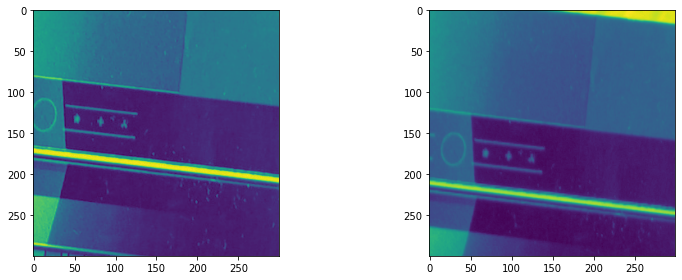

In [219]:
imshows([t_path, s_patch])

In [225]:
y = patch_matrix_yield(target_gray, source_gray, patch_size=500, warp_mode=warp_mode, warp_matrix=warp_matrix, criteria=criteria)

results = np.eye(2, 3, dtype=np.float32)
for i in range(100):
    results += y.__next__()

results / 100

error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-k1ohfcms\opencv\modules\video\src\ecc.cpp:572: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'cv::findTransformECC'


In [175]:
h, w, _ = target_img.shape

In [183]:
aligned = cv2.warpAffine(source_img, results / 100, (w, h), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

In [184]:
warp_matrix

array([[ 1.      ,  0.      , 36.44945 ],
       [ 0.      ,  1.      , 22.500954]], dtype=float32)

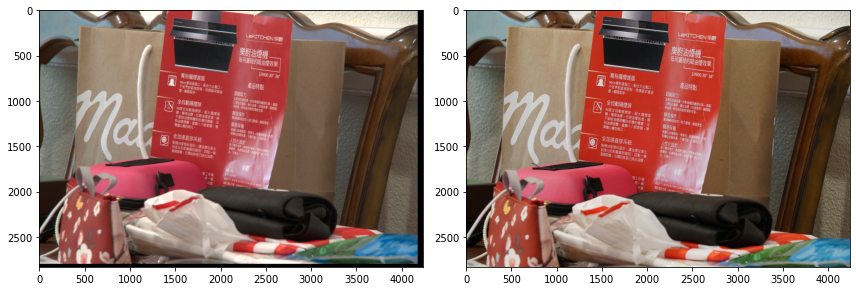

In [185]:
imshows([aligned, target_img])

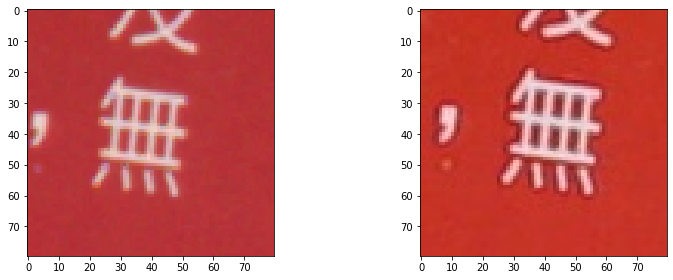

In [198]:
imshows([source_img[1280:1360, 1980:2060], target_img[1270:1350, 1960:2040]])

In [83]:
def sum_aligned_image(image_aligned, image_set):
    sum_img = np.float32(image_set[0]) * 1. / len(image_aligned)
    sum_img_t = np.float32(image_aligned[0]) * 1. / len(image_aligned)
    identity_transform = np.eye(2, 3, dtype=np.float32)
    r, c = image_set[0].shape[0:2]
    for i in range(1, len(image_aligned)):
        sum_img_t += np.float32(image_aligned[i]) * 1. / len(image_aligned)
        image_set_i = cv2.warpAffine(image_set[i], identity_transform, (c, r),
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        sum_img += np.float32(image_set_i) * 1. / len(image_aligned)
    return sum_img_t, sum_img


In [84]:
sum_img_t, sum_img = sum_aligned_image([aligned, target_img], [source_img, target_img])

In [85]:
sum_img_t.shape

(2832, 4236, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


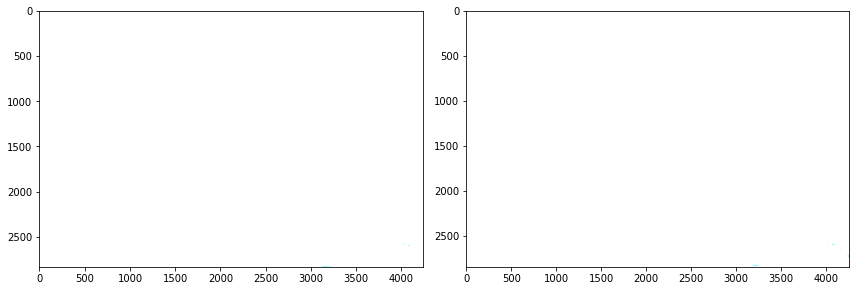

In [86]:
imshows([sum_img_t, sum_img])